In [23]:
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import gseapy as gp
import scvelo as scv
from tqdm.auto import tqdm
from pathlib import Path

# Paths and utils
root = Path('../../')
figure_path = root / 'results/figures/Neutrophils/'
figure_path.mkdir(parents=True, exist_ok=True)
table_path = root / 'results/tables/'
signatures_path = root / 'resources/'
import yaml
with open(root / 'config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
data_path = config['data_path']

# Set plotting style
from matplotlib import rcParams
# Type 2/TrueType fonts
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# Arial font
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
%matplotlib inline

In [30]:
# utility functions used for analysis

import scanpy as sc
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
import os
import seaborn as sns
import gseapy as gp
import statsmodels.api as sm
import decoupler as dc

from functools import wraps
from tqdm.auto import tqdm
from warnings import warn
from pathlib import Path
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind, zscore
from scipy.sparse import issparse
from scipy.cluster.hierarchy import distance, linkage, dendrogram

signatures_path_ = root / 'resources/'


# Newer names, more accurate
organism_rename_dict = {
    'Dwarfhamster': 'Roborovski hamster',
    'Goldhamster': 'Syrian hamster'
}
time_rename_dict = {
    'D0': '0 dpi',
    'D2': '2 dpi',
    'D3': '3 dpi',
    'D5': '5 dpi',
    'E14': '14 dpi'
}
dosage_rename_dict = {
    'no dose': '0 pfu',
    'low dose': r'$1\times10^4$ pfu',
    'high dose': r'$1\times10^5$ pfu'
}

def get_key_values(adata, key):
    if key in adata.var_names:
        from scipy.sparse import issparse
        return adata[:, key].X.A.T[0] if issparse(adata.X) else adata[:, key].X.T[0]
    elif key in adata.obs.keys():
        return adata.obs[key]
    else:
        raise ValueError(f'Could not find key {key} in neither obs nor var_names.')

def rsum(X, axis):
    # handles sparse sum, returns array instead of matrix object
    return np.ravel(np.sum(X, axis=axis))

def extract_df(adata, keys):
    df = pd.DataFrame(index=adata.obs_names)
    for key in keys:
        df[key] = get_key_values(adata, key)
    return df

def cluster_matrix(matrix, how='row', return_order=False, method='centroid'):
    '''
    Hierarchical clustering of a matrix/dataframe. `how` can be 'col', 'row' or 'both' (default: 'row').
    '''
    if how not in ['col', 'row', 'both']:
        raise ValueError('Value for "how" must be row or col.')
    if how!='both':
        M = matrix if how=='row' else matrix.T
        dist = distance.pdist(M)
        link = linkage(dist, method=method)
        dend = dendrogram(link, no_plot=True)
        order = np.array(dend['leaves'], dtype=int)
        if return_order:
            return order
        elif isinstance(matrix, pd.DataFrame):
            return matrix.iloc[order] if how=='row' else matrix.iloc[:, order]
        else:
            return matrix[order] if how=='row' else matrix[:, order]
    else:
        if return_order:
            warn('Returning order when clustering both row and col is not supported.')
        matrix_ = cluster_matrix(matrix, how='row', return_order=False, method=method)
        return cluster_matrix(matrix_, how='col', return_order=False, method=method)

def format_one_pval(val, star='*'):
    """
    Format p-value for display in a table or plot.
    
    Parameters
    ----------
    val : float
        p-value.
    
    Returns
    -------
    formatted : str
        Formatted p-value.
    """
    if val > 0.05:
        return 'ns'
    elif val < 0.0001:
        return star*4  # '****'
    elif val < 0.001:
        return star*3  # '***'
    elif val < 0.01:
        return star*2  # '**'
    elif val < 0.05:
        return star  # '*'
    else:
        return ''  # NONE and such

def format_pvals(vals):
    """
    Format p-values for display in a table or plot.
    pval format:
    Symbol  Meaning
    ns      P > 0.05
    *       P ≤ 0.05
    **      P ≤ 0.01
    ***     P ≤ 0.001
    ****    P ≤ 0.0001 (For the last two choices only)
    
    Parameters
    ----------
    vals : np.array
        p-values.
    
    Returns
    -------
    formatted : np.array
        Formatted p-values.
    """
    
    return np.vectorize(format_one_pval)(vals)

def specify_genes(genes, source_species='mouse', target_species='human'):
    """Translates gene symbols from a species to another using orthologs."""
    genes = genes if isinstance(genes, list) else list(genes) if (isinstance(genes, np.ndarray) or isinstance(genes, pd.Index)) else [genes]
    # load human-mouse orthology
    tab = pd.read_csv('/Users/peidli/work/projects/PanCov19_Hamster/resources/homology_human_mouse/HMD_HumanPhenotype.rpt', sep='\t',
                  names=['human', 'human_gene_number (HGNC)', 'mouse', 'mouse_gene_number (MGI)', 'mouse protein'], usecols=[0,1,2,3,4])
    human_mouse_orthology_dict = dict(zip(tab.human, tab.mouse))
    mouse_human_orthology_dict = {key: value for (value, key) in human_mouse_orthology_dict.items()}
    # translate genes
    # TODO the mapping could lead to duplicate genes, is that a problem?
    if source_species=='mouse' and target_species=='human':
        return [mouse_human_orthology_dict[x] if x in mouse_human_orthology_dict.keys() else x.upper() for x in genes]
    elif source_species=='human' and target_species=='mouse':
        return [human_mouse_orthology_dict[x] if x in human_mouse_orthology_dict.keys() else x.capitalize() for x in genes]
    elif target_species is 'mouse':
        return [x.capitalize() for x in genes]
    elif target_species is 'human':
        return [x.upper() for x in genes]
    else:
        raise ValueError('Species '+target_species+' not known.')

def score_genes(adata, gene_list, score_name, species='human', **kwargs):
    """Scores genes in gene_list and adds scores to adata.obs[score_name]."""
    gene_list_ = specify_genes(gene_list, target_species=species)
    sc.tl.score_genes(adata, gene_list_, score_name=score_name)

def sanitize_name(s):
    for rdict in [organism_rename_dict, time_rename_dict, dosage_rename_dict]:
        for old, new in rdict.items():
            s = s.replace(old, new)
    return s.replace('_', ', ')

### GSEA ###

# Will annotate in plot significant gene sets containing any of these keywords
keywords = ['infection', 'sars', 'covid', 'corona', 'innate', 'immune', 'cytokine', 'interferon', 
            'tgf', 'MTOR', 'Lung', 'neutro', 'apoptosis', 'hypoxia', 'nod-like' 'inflammation', 'inflammatory',
           'DNA-sensing', 'calcium', 'influenza', 'hepatitis', 'jak', 'stat', 'il-', 'virus']

def extract_gsea_results(prerank_object, gene_sets):
    # prepare data
    Y = prerank_object.res2d.copy()
    
    # clear names
    Y['source']=None
    Y['Enrichment_Term']=None
    for index, row in Y.iterrows():
        for gene_set in gene_sets:
            if gene_set in row.Term:
                Y.loc[index, 'source'] = gene_set
                Y.loc[index, 'Enrichment_Term'] = row.Term.replace('__', '_').replace(gene_set+'_', '')
    
    Y = Y.sort_values('NES')
    y = -np.log10(Y['FDR q-val'].astype(float))
    Y['score'] = np.clip(y, 0, 5)# np.max(y[y!=np.infty]))
    Y['significance_str'] = format_pvals(Y['FDR q-val'])
    
    # annotate immune related terms
    Y['immune_related'] = False
    for index, row in Y.iterrows():
        if any([k.lower() in row.Term.lower() for k in keywords]):
            Y.loc[index, 'immune_related'] = True
    return Y

def Uplot(prerank_object, gene_sets=["KEGG_2021_Human", 'MSigDB_Hallmark_2020'], ax=None, legend=True):
    ax = pl.subplots(figsize=(8,6))[-1] if ax is None else ax
    
    Y = extract_gsea_results(prerank_object, gene_sets)
    
    # annotate with arrow
    x = Y[Y.Term=='MSigDB_Hallmark_2020__Inflammatory Response'].NES
    y = Y[Y.Term=='MSigDB_Hallmark_2020__Inflammatory Response'].score
    ax.annotate('Inflammatory\nResponse', (x, y), xytext=(x+0.1, y-0.4), arrowprops=dict(arrowstyle="->",
                        connectionstyle="arc3"), fontsize=5)
    
    sns.scatterplot(data=Y, x='NES', y='score', ax=ax, hue='immune_related', palette=['grey', 'red'], legend=legend)
                    #hue='source', hue_order=np.sort(Y.source.unique()))
    
    ax.set_xlim(-2.5, 2.5)
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    if legend:
        ax.axhline(-np.log10(0.05), label=r'$\alpha=0.05$')
        ax.legend(title='GSEA\nSignificance')#, bbox_to_anchor=(1,0.5))

    ax.set_xlabel(f'GSEA Normalized Enrichment Score')
    ax.set_ylabel('-Log10(q-value)', loc='top')
    
def do_gsea(datasets, celltype, key, load_key, gene_sets=["KEGG_2021_Human", 'MSigDB_Hallmark_2020']):
    if load_key==None:
        if key=='severity':
            load_key = 'severity'
        elif key=='infection':
            load_key = 'COVID19_vs_healthy'
        else:
            raise ValueError(f'Load_key for key {key} unknown. Please supply!')
    
    # load deseq results
    dfs =[pd.read_csv(root / f'results/DESeq2/{key}/{celltype}_{d}_{load_key}.csv', index_col=0) for d in datasets]

    # humanize hamster genes
    for i, df_ in enumerate(dfs):
        ds = datasets[i]
        if 'hamster' in ds:
            df_.index = specify_genes(df_.index, 'mouse', 'human')  # map to human using biomart
            df_ = df_[~df_.index.duplicated(keep='first')]  # remove dups
    
    # GSEA for Pros:
    ranked_genes = []
    for i, df in enumerate(dfs):
        # Step 1: Filter by mean expression (low expression makes statistics unreliable)
        df = df[df.baseMean > 10]
        # Step 2: Compute the neglog10 of p-value without multiple testing correction 
        # (we only want an ordering, the correction might lead to more draws in ranking)
        df['score'] = - np.log10(df.pvalue)
        # Step 3: Add sign from lfc
        df['signed_score'] = df.score * np.sign(df.log2FoldChange)
        # Step 4: Use that to rank genes
        df = df[~df.signed_score.isna()].sort_values('signed_score', ascending=False)
        ranked_genes.append(df[['signed_score']])
    
    # run GSEA
    pre_res = []
    for d, rank in zip(datasets, ranked_genes):
        pre_res_ = gp.prerank(rnk=rank,
                             gene_sets=gene_sets,
                             threads=8,
                             min_size=15,  # gene sets with less than that many genes in data are ignored
                             max_size=1000,  # gene sets with more than that many genes in data are ignored
                             permutation_num=1000,
                             outdir=None, # don't write to disk
                             seed=42,
                             verbose=False
                            )
        pre_res.append(pre_res_)
    return pre_res

def DC_do_GSEA(df, gene_sets=['KEGG_2021_Human', 'MSigDB_Hallmark_2020']):
    # humanize hamster genes
    df.index = specify_genes(df.index, 'mouse', 'human')  # map to human using biomart
    df = df[~df.index.duplicated(keep='first')]  # remove dups
    df['signed_score'] = df.spearman_r
    # Use that to rank genes
    df = df[~df.signed_score.isna()].sort_values('signed_score', ascending=False)
    rank = df[['signed_score']]

    # run GSEA
    pre_res_ = gp.prerank(rnk=rank,
                            gene_sets=gene_sets,
                            threads=8,
                            min_size=15,  # gene sets with less than that many genes in data are ignored
                            max_size=1000,  # gene sets with more than that many genes in data are ignored
                            permutation_num=1000,
                            outdir=None, # don't write to disk
                            seed=42,
                            verbose=False
                        )
    return pre_res_.res2d

def plot_timecourse(adata, key, x='time', hue='organism', ci=99, markers=True, linewidth=2, ax=None, **kwargs):
    keys = [key] if type(key)==str else key
    N = len(keys)
    axs = pl.subplots(1,N, figsize=[6*N,4], dpi=100)[-1] if ax is None else ax
    axs = [axs] if N==1 else axs
    for key, ax in zip(keys, axs):
        df = extract_df(adata, [key, x, hue])
        sns.lineplot(data=df, y=key, x=x, hue=hue, ci=ci, markers=markers, linewidth=linewidth, ax=ax, **kwargs)
        ax.set_title(key)

def plot_timecourse_dose(adata, key, x='time', ci=99, markers=True, linewidth=2, ax=None, **kwargs):
    keys = [key] if type(key)==str else key
    N = len(keys)
    with sns.axes_style('whitegrid'):
        axs = pl.subplots(1,N, figsize=[8*N,5], dpi=80)[-1] if ax is None else ax
    axs = [axs] if N==1 else axs
    for key, ax in zip(keys, axs):
        df = extract_df(adata, [key, x, 'organism', 'dosage', 'organism_dosage'])
        df_ = df[df.organism_dosage=='Dwarfhamster_no dose']
        df = df[df.organism_dosage!='Dwarfhamster_no dose']
        df_['organism_dosage'] = 'Dwarfhamster_low dose'
        df = pd.concat([df, df_])
        df_['organism_dosage'] = 'Dwarfhamster_high dose'
        df = pd.concat([df, df_])
        df.organism_dosage[df.organism_dosage.isin(['Goldhamster_no dose', 'Goldhamster_high dose'])] = 'Goldhamster'
        df.index = np.sum(np.vstack([df.index, np.arange(len(df)).astype(str)]), axis=0)
        sns.lineplot(data=df, y=key, x=x, hue='organism_dosage', ci=ci, markers=markers, linewidth=linewidth, ax=ax, **kwargs)
        ax.set_title(key)

tab = pd.read_csv(root / 'resources/biomart_mouse_gene_protein.csv')
def annotate_genes(df, tab):
    for gene in tqdm(df.index):
        if gene in tab['Gene name'].values:
            stab = tab[tab['Gene name']==gene]
            for c in ['Gene stable ID', 'Protein stable ID', 'Gene type', 'Gene Synonym', 'Gene description']:
                v = stab[c].unique()
                v = v[~pd.isna(v)]
                if len(v)==1:
                    df.loc[gene, c] = v[0]
                else:
                    df.loc[gene, c] = ', '.join(v)
    return df

def lowess_with_confidence_bounds(
    x, y, eval_x, N=200, conf_interval=0.95, lowess_kw=None
):
    """
    # https://www.statsmodels.org/dev/examples/notebooks/generated/lowess.html
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    for i in tqdm(range(N), leave=False):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]

        smoothed_values[i] = sm.nonparametric.lowess(
            exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top

def l2fc(x,y, pseudo_count=0.001):
    """Log2 fold change between two vectors x and y."""
    return np.log2(np.mean(x)+pseudo_count) - np.log2(np.mean(y)+pseudo_count)

def mklist(str_or_list):
    """Make a list from a string or list."""
    return [str_or_list] if isinstance(str_or_list, str) else str_or_list

def differential_test(adata, keys, groupby, replicate_key, control=None, correction_method='fdr_bh', sort_groups=True):
    """Perform differential test on keys (from adata.X or adata.obs) w.r.t. a grouping with specifyable control groups.

    Uses t-test and by default corrects for multiple testing. Control groups can be specified for all groups or
    as dict for every group separately.
    Returns three pandas DataFrames: pval_adj_tab, l2fc_tab, fc_tab

    Parameters
    ----------
    adata: AnnData object
        The AnnData object to extract data from.
    keys: str or list of str
        Keys to perform testing for.
        Can be gene names or keys of adata.obs.
    groupy: str
        Key to categorical column in adata.obs.
        Defines the groups for testing.
    replicate_key: str
        Key to categorical column in adata.obs.
        Defines the replicates for testing.
    control: str, list of str, or dict (default: `None`)
        Defines the control group(s) to test against.
        All values of control must be categories in adata.obs[groupby].
        There are different ways of setting control:
        - str: defines this group as control for all groups
        - list of str: defines these groups as control for all groups
        - dict: Dict must map every group of interest to at least one other group.
    correction_method: str (default: `'fdr_bh'`)
        Multiple testing correction method. Defaults to Benjamini-Hochberg.
        Can be any viable value for parameter 'method'
        statsmodels.stats.multitest.multipletests.
    sort_groups: bool (default: `True`)
        Wether to sort the groups, ignoring the categorical sorting in adata.obs[groupby].

    Returns
    -------
    pandas.DataFrames
        pval_adj_tab, l2fc_tab, fc_tab

    """

    groups = pd.unique(adata.obs[groupby])
    groups = np.sort(groups) if sort_groups else groups
    groups = list(pd.unique(list(control.keys()))
                  ) if isinstance(control, dict) else groups

    n_groups = len(groups)
    if isinstance(keys, dict):
        # convert dict values to list, ignore keys of dict.
        keys = np.concatenate(list(keys.values()))
    keys = mklist(keys)
    not_found = [
        key for key in keys if key not in adata.var_names and key not in adata.obs.keys()]
    if len(not_found) > 0:
        warn(f"Could not find these keys: {not_found}")
        keys = [x for x in keys if x not in not_found]

    pval_tab = pd.DataFrame(index=groups, columns=keys, dtype=float)
    l2fc_tab = pd.DataFrame(index=groups, columns=keys, dtype=float)
    fc_tab = pd.DataFrame(index=groups, columns=keys, dtype=float)

    # Pseudobulked into replicates while recording groupby
    X = extract_df(adata, keys + [replicate_key, groupby]).groupby(
        [replicate_key, groupby]).mean().dropna().reset_index(level=1)
    grouping = X[groupby]

    for key in keys:
        for g in groups:
            x = X[grouping == g][key]
            # determin control values
            if control == None:
                # test group against all other groups as control
                xc = X[grouping != g][key]
            elif isinstance(control, list) or control in groups:
                # test between each group and the control group(s)
                xc = X[np.isin(grouping, mklist(control))][key]
            elif isinstance(control, dict):
                # test between non-control group and control group, where control group if specifically given for each group
                xc = X[np.isin(grouping, mklist(control[g]))][key]
            else:
                raise ValueError(
                    f'Control group {control} was not found in groups {groups} given by groupby {groupby}.')

            pval_tab.loc[g, key] = ttest_ind(x, xc)[1]
            l2fc_tab.loc[g, key] = l2fc(x, xc)
            fc_tab.loc[g, key] = np.mean(x) - np.mean(xc)

    if correction_method != None:
        # correct pvals
        shape = pval_tab.values.shape
        K = np.multiply(*shape)
        mask = pval_tab.isnull()
        pval_tab[mask] = 0
        rejected, pvals_corrected, _, _ = multipletests(
            pval_tab.values.reshape(K), alpha=0.05, method=correction_method)
        pval_adj_tab = pd.DataFrame(np.array(pvals_corrected).reshape(
            shape), index=groups, columns=keys)
        pval_adj_tab[mask] = None
    else:
        pval_adj_tab = pval_tab
    return pval_adj_tab, l2fc_tab, fc_tab

def plot_differential_test(adata, keys, groupby, replicate_key, control=None, change='l2fc', correction_method='fdr_bh', 
                            sort_groups=True, kick_control=True, show=True,ax=None, center=0, robust=True, 
                            cluster=None, nan_color='lightgrey', swap_axes=False, annotate=True, **kwargs):
    '''
    Change may be 'fc' or 'l2fc'.
    '''
    pval_adj_tab, l2fc_tab, fc_tab = differential_test(
        adata, keys, groupby, replicate_key, control, correction_method, sort_groups)
    change_tab = eval(f'{change}_tab')
    if kick_control and (isinstance(control, str) or isinstance(control, list)):
        mask = [x for x in change_tab.index if x not in mklist(control)]
        change_tab = change_tab.loc[mask]
        pval_adj_tab = pval_adj_tab.loc[mask]
    if cluster != None:
        order = cluster_matrix(change_tab.fillna(
            0), how=cluster, return_order=True, method='centroid')
        change_tab = change_tab.iloc[order] if cluster == 'row' else change_tab.iloc[:, order]
        pval_adj_tab = pval_adj_tab.iloc[order] if cluster == 'row' else pval_adj_tab.iloc[:, order]

    if annotate:
        cg = sns.heatmap(change_tab.T if swap_axes else change_tab,
                         cmap='bwr', center=center, robust=robust,
                         mask=pd.isna(pval_adj_tab.T) if swap_axes else pd.isna(
                             pval_adj_tab),
                         annot=format_pvals(pval_adj_tab.values.T) if swap_axes else format_pvals(pval_adj_tab.values), fmt='',
                         ax=ax, **kwargs)
    else:
        cg = sns.heatmap(change_tab.T if swap_axes else change_tab,
                         cmap='bwr', center=center, robust=robust,
                         mask=pd.isna(pval_adj_tab.T) if swap_axes else pd.isna(
                             pval_adj_tab),
                         ax=ax, **kwargs)
    if nan_color != None:
        cg.set_facecolor(nan_color)
    ax = pl.gca() if ax == None else ax
    ax.set_title(f'{change} & adjusted pvalues\nacross {groupby}')

    # annotate columns if a dict is given
    if type(keys) == dict:
        if cluster == 'col':
            # Obviously the cols need to stay grouped as in the dict, otherwise no brackets possible
            warn(
                'Clustering and column annotations can not be combined! Skipping annotation...')
        else:
            pos = 0
            for key, value in keys.items():
                # throw out genes not found
                value = [x for x in value if x in change_tab.columns]
                x = len(value) / 2 + pos - 0.5
                width = len(value)
                raise NotImplementedError('This is not finished yet!')
                pos += len(value)
    if show:
        pl.show()
    else:
        return ax

def get_foldchanges(adata, keys, groupby, control=None, log2=True, sort_groups=True):
    """Computes L2FCs or FCs of given keys (from adata.X or adata.obs) w.r.t. a grouping with specifyable control groups.
    Control groups can be specified for all groups as str or
    as dict for every group separately.

    Parameters
    ----------
    adata: AnnData object
        The AnnData object to extract data from.
    keys: str or list of str
        Keys to perform testing for.
        Can be gene names or keys of adata.obs.
    groupy: str
        Key to categorical column in adata.obs.
        Defines the groups for testing.
    control: str, list of str, or dict (default: `None`)
        Defines the control group(s) to compare against.
        All values of control must be categories in adata.obs[groupby].
        There are different ways of setting control:
        - str: defines this group as control for all groups
        - list of str: defines these groups as control for all groups
        - dict: Dict must map every group of interest to at least one other group.
    sort_groups: bool (default: `True`)
        Wether to sort the groups, ignoring the categorical sorting in adata.obs[groupby].

    Returns
    -------
    pandas.DataFrame
        l2fc_tab or fc_tab

    """

    groups = pd.unique(adata.obs[groupby])
    groups = np.sort(groups) if sort_groups else groups
    groups = list(pd.unique(list(control.keys()))) if isinstance(control, dict) else groups

    n_groups = len(groups)
    if isinstance(keys, dict):
        # convert dict values to list, ignore keys of dict.
        keys = np.sum(list(keys.values()))
    keys = mklist(keys)
    not_found = [key for key in keys if key not in adata.var_names and key not in adata.obs.keys()]
    if len(not_found)>0:
        warn(f"Could not find these keys: {not_found}")
        keys = [x for x in keys if x not in not_found]
    grouping = adata.obs[groupby]

    fc_tab = pd.DataFrame(index=groups, columns=keys, dtype=float)
    for key in keys:
        # group-wise values
        X = get_key_values(adata, key)

        for g in groups:
            x = X[grouping==g]
            # determin control values
            if control==None:
                # comparison group against all other groups as control
                xc = X[grouping!=g]
            elif isinstance(control, list) or control in groups:
                # comparison between each group and the control group(s)
                xc = X[np.isin(grouping, mklist(control))]
            elif isinstance(control, dict):
                # comparison between non-control group and control group, where control group if specifically given for each group
                xc = X[np.isin(grouping, mklist(control[g]))]
            else:
                raise ValueError(f'Control group {control} was not found in groups {groups} given by groupby {groupby}.')

            fc_tab.loc[g, key] = l2fc(x, xc) if log2 else np.mean(x) - np.mean(xc)
            
    return fc_tab 

def plot_differential_test(adata, keys, groupby, replicate_key, control=None, change='l2fc', correction_method='fdr_bh', 
                            sort_groups=True, kick_control=True, show=True,ax=None, center=0, robust=True, 
                            cluster=None, nan_color='lightgrey', swap_axes=False, annotate=True, 
                            row_order=None,
                            **kwargs):
    '''
    Change may be 'fc' or 'l2fc'.
    '''
    pval_adj_tab, l2fc_tab, fc_tab = differential_test(
        adata, keys, groupby, replicate_key, control, correction_method, sort_groups)
    change_tab = eval(f'{change}_tab')
    if kick_control and (isinstance(control, str) or isinstance(control, list)):
        mask = [x for x in change_tab.index if x not in mklist(control)]
        change_tab = change_tab.loc[mask]
        pval_adj_tab = pval_adj_tab.loc[mask]
    if cluster != None:
        order = cluster_matrix(change_tab.fillna(
            0), how=cluster, return_order=True, method='centroid')
        change_tab = change_tab.iloc[order] if cluster == 'row' else change_tab.iloc[:, order]
        pval_adj_tab = pval_adj_tab.iloc[order] if cluster == 'row' else pval_adj_tab.iloc[:, order]
    if row_order != None:
        change_tab = change_tab.loc[row_order]
        pval_adj_tab = pval_adj_tab.loc[row_order]
        
    if annotate:
        cg = sns.heatmap(change_tab.T if swap_axes else change_tab,
                         cmap='bwr', center=center, robust=robust,
                         mask=pd.isna(pval_adj_tab.T) if swap_axes else pd.isna(
                             pval_adj_tab),
                         annot=format_pvals(pval_adj_tab.values.T) if swap_axes else format_pvals(pval_adj_tab.values), fmt='',
                         ax=ax, **kwargs)
    else:
        cg = sns.heatmap(change_tab.T if swap_axes else change_tab,
                         cmap='bwr', center=center, robust=robust,
                         mask=pd.isna(pval_adj_tab.T) if swap_axes else pd.isna(
                             pval_adj_tab),
                         ax=ax, **kwargs)
    if nan_color != None:
        cg.set_facecolor(nan_color)
    ax = pl.gca() if ax == None else ax
    ax.set_title(f'{change} & adjusted pvalues\nacross {groupby}')
    if show:
        pl.show()
    else:
        return ax


def intersect_many(arrays):
    """Intersect many arrays, even more than two."""
    X = arrays[0]
    for Y in arrays:
        X = np.intersect1d(X,Y)
    return X


def shut_up_scanpy(func):
    """Tell scanpy to shut up."""
    @wraps(func)  # does these attribute copies commented out below...
    def silent_wrapper(*args, **kwargs):
        verbosity = sc.settings.verbosity.value
        sc.settings.verbosity = 0
        func(*args, **kwargs)
        sc.settings.verbosity = verbosity
    # silent_wrapper.__name__=func.__name__
    # silent_wrapper.__annotations__=func.__annotations__
    # silent_wrapper.__doc__=func.__doc__
    # silent_wrapper.__defaults__=func.__defaults__
    return silent_wrapper


@shut_up_scanpy
def score_hallmarks(adata, subset='all', signatures_path=signatures_path_, species='human'):
    # subset can be a list of hallmarks, 'organoid' (), 'CRC' (~18) or 'all' (50 scores)
    signatures_path = Path(signatures_path) if type(signatures_path) is str else signatures_path
    tab = pd.read_csv(signatures_path / 'msigdb/hallmark/h.all.v6.2.symbols.gmt', sep='\t', index_col=0, header=None).drop(1, axis=1).T
    hallsigs={hallmark : tab[hallmark][~pd.isna(tab[hallmark])].values for hallmark in tab.columns}
    if isinstance(subset, list):
        selection = subset
    elif subset == 'organoid':
        selection = ['HALLMARK_DNA_REPAIR', 'HALLMARK_WNT_BETA_CATENIN_SIGNALING', 'HALLMARK_APOPTOSIS']
    elif subset == 'CRC':  # TODO this list is bugged, some entries do not exist
        selection = ['HALLMARK_DNA_REPAIR', 'HALLMARK_WNT_BETA_CATENIN_SIGNALING', 'HALLMARK_APOPTOSIS',
        'HALLMARK_NOTCH_SIGNALING', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_HYPOXIA', 'HALLMARK_TGF_BETA_SIGNALING',
        'HALLMARK_MITOTIC_SPINDLE', 'HALLMARK_MTORC1_SIGNALING', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING', 'HALLMARK_PROTEIN_SECRETION',
        'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_OXIDATIVE_PHOSPHORYLATION',
        'HALLMARK_P53_PATHWAY', 'HALLMARK_ANGIOGENESIS', 'HALLMARK_KRAS_SIGNALING_UP', 'HALLMARK_KRAS_SIGNALING_DN',
        'HALLMARK_GLYCOLYSIS']
    elif subset == 'all':
        selection = hallsigs.keys()
    else:
        raise ValueError('Please select a valid subset of hallmark to use. You can also choose "all".')
    for hm in tqdm(selection):
        score_genes(adata, hallsigs[hm], score_name=hm, species=species)

def get_genefamily_percentage(adata, key='MT-', start=True, name='mito'):
    keys = key if isinstance(key, list) else [key, '____ignore____']
    if start:
        family_genes = np.logical_or(*[adata.var_names.str.startswith(k) for k in keys])
    else:
        family_genes = np.logical_or(*[adata.var_names.str.endswith(k) for k in keys])
    if issparse(adata.X):
        adata.obs['percent_'+name] = np.sum(
            adata[:, family_genes].X, axis=1).A1 * 100 / np.sum(adata.X, axis=1).A1
    else:
        adata.obs['percent_'+name] = np.sum(
            adata[:, family_genes].X, axis=1) * 100 / np.sum(adata.X, axis=1)

def get_mito_percentage(adata, species='human'):
    key = 'MT-' if species == 'human' else 'mt-'
    get_genefamily_percentage(adata, key=key, start=True, name='mito')

def get_ribo_percentage(adata, species='human'):
    key = specify_genes(['RPS', 'RPL'], target_species=species)
    get_genefamily_percentage(adata, key=key, start=True, name='ribo')
    
def run_progeny(adata, species='human', top=100):
    """Run progeny on adata and add progeny scores to adata.obs"""
    model = dc.get_progeny(organism=species, top=top)
    dc.run_mlm(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True, use_raw=False)
    for key in adata.obsm['mlm_estimate'].columns: adata.obs[f'{key}_progeny'] = adata.obsm['mlm_estimate'][key]
    
def obs_obs_aggregate_heatmap(adata, obs_keys, groupby, standard_scale='var',
        show=True, swap_axes=True, figsize=[10,3], obs_rotation=0, plot=True, **kwargs):
    """
    Show a heatmap of pseudobulked (means) obs_keys grouped by groupby.

    Parameters
    ----------
    data: :class:`~anndata.AnnData`
        Annotated data matrix.
    obs_keys : `list` or `np.ndarray` of numeric columns in adata.obs
        Keys of observations to show (e.g. signatures or QC values).
    groupby : `str` of categorical column in adata.obs
        Key of observations grouping to consider.
    standard_scale : `'var'`, `'group'` or `None`/`False` (default: `'var'`)
        Axis to zscore normalization.
    obs_rotation: float or int (default: 0)
        Rotation of the obs_key labels.
    show: bool (default: True)
        Whether to call matplotlib.pyplot.show() in function call automatically.
    plot: bool (default: True)
        Whether to plot the heatmap.
    Returns
    -------
    pandas DataFrame
        DataFrame source for the heatmap.
    """
    X = adata.obs.groupby(groupby).mean()[obs_keys]
    X = X.T if swap_axes else X
    Z = zscore(X.values, axis=1) if standard_scale == 'var' else zscore(X.values, axis=0) if standard_scale == 'group' else X.values
    X = pd.DataFrame(Z, index=X.index, columns=X.columns)
    if plot:
        pl.figure(figsize=figsize)
        sns.heatmap(X, **kwargs)
        pl.xlabel(groupby)
        pl.yticks(rotation=obs_rotation) if swap_axes else pl.xticks(rotation=obs_rotation)
        if show: pl.show()
    return X

In [25]:
data_path = Path('/Users/peidli/work/data/COVID')

# Loading

In [26]:
superdata = sc.read(data_path / "Pancov19_prepd_all.h5")

# Import color options
import yaml
with open(root / 'config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
celltype_colors = config['celltype_colors']
celltype_rough_colors = config['celltype_rough_colors']
organism_colors = config['organism_colors']
organism_dosage_colors = config['organism_dosage_colors']
dosage_colors = config['dosage_colors']

# Newer names, more accurate
organism_rename_dict = {
    'Dwarfhamster': 'Roborovski hamster',
    'Goldhamster': 'Syrian hamster'
}
time_rename_dict = {
    'D0': '0 dpi',
    'D2': '2 dpi',
    'D3': '3 dpi',
    'D5': '5 dpi',
    'E14': '14 dpi'
}
dosage_rename_dict = {
    'no dose': '0 pfu',
    'low dose': r'$1\times10^4$ pfu',
    'high dose': r'$1\times10^5$ pfu'
}

def sanitize_name(s):
    for rdict in [organism_rename_dict, time_rename_dict, dosage_rename_dict]:
        for old, new in rdict.items():
            s = s.replace(old, new)
            
    return s.replace('_', ', ')

from matplotlib.cm import get_cmap
# not super pretty, but ok for now
time_colors = {
    'D0': 'grey',
    'D2': get_cmap('viridis_r')(0),
    'D3': get_cmap('viridis_r')(1/3),
    'D5': get_cmap('viridis_r')(2/3),
    'E14': get_cmap('viridis_r')(1),
              }
    
# Translate color palettes to new names as well
Organism_colors = {sanitize_name(key) : value for key, value in config['organism_colors'].items()}
Organism_Dosage_colors = {sanitize_name(key) : value for key, value in config['organism_dosage_colors'].items()}
Dosage_colors = {sanitize_name(key) : value for key, value in config['dosage_colors'].items()}
Time_colors = {sanitize_name(key) : value for key, value in time_colors.items()}

# define control dicts for DE testing etc.
control_dict = {x: ['pr_D0_Z1_L','pr_D0_Z2_L','pr_D0_Z3_L'] if 'pr' in x else ['ma_d0_lung_1', 'ma_d0_lung_2', 'ma_d0_lung_3'] for x in pd.unique(superdata.obs['orig.ident']) if '0' not in x}
control_dict_odt = {x: 'Dwarfhamster_no dose_D0' if 'Dwarfhamster' in x else 'Goldhamster_no dose_D0' for x in superdata.obs.organism_dosage_time.unique() if 'D0' not in x}

ValueError: color key is invalid! pass valid observation annotation or a gene name

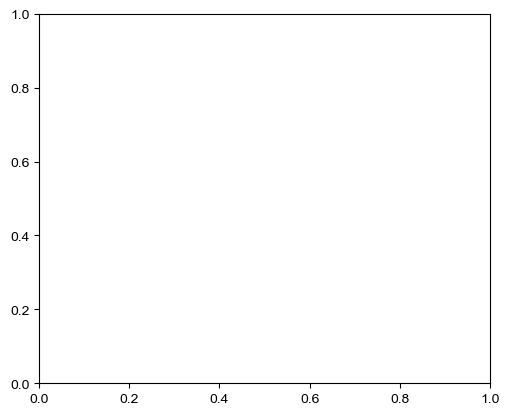

In [21]:
genes = ['Sidt', 'Selp']
scv.pl.scatter(superdata, basis='umap', color=genes)

In [41]:
genes = ['Sidt1', 'Sidt2', 'Selplg', 'Selp']
for gene in genes:
    print(gene, 'in var_names:\t', gene in superdata.var_names)

Sidt1 in var_names:	 True
Sidt2 in var_names:	 True
Selplg in var_names:	 True
Selp in var_names:	 False


In [42]:
superdata.var_names[superdata.var_names.str.startswith('Sel')]

Index(['Sel1l', 'Sel1l3', 'Sele', 'Selenbp2', 'Selenof', 'Selenoh', 'Selenoi',
       'Selenok', 'Selenom', 'Selenon', 'Selenoo', 'Selenop', 'Selenos',
       'Selenot', 'Selenow', 'Sell', 'Selplg'],
      dtype='object')